## Use the xG predictions to score the model in terms of money gained or lost
Components needed:
1. Model xG predictions aggregated to the team/game level
2. ML odds of each particular team/game
3. Score/result of each game

Restrictions that we will put in place to help choose what bets to place:
1. Only wager on bets that have greater than +0.30 unit expected value
2. OPTIONAL: (Only wager on bets that have odds between [-250, +300])

Steps to accomplish this:
1. Assign each row in the teams xG df the correct game ID located in the season scores df
2. Group the teams xG df by the game ID and calculate the probability of winning (using poisson function)
3. Join the probabilities to the odds data frame
4. Get the EV of each bet using the odds and the probability of each team winning
5. Decide which wagers to place using the restrictions above
6. Join which bets won using the scores of each game
7. Create column containing the gain/loss in terms of units of each bet. If we did not place a bet, the value is 0
8. Sum the profit column to determine the total gain/loss over the betting period


In [154]:
# Libraries
import pandas as pd
from scipy.stats import poisson
import seaborn as sns

In [155]:
# Poisson win rate function
def get_poisson_win_rate(df_group):
    # Gather the expected goals for each team in the group
    xg = df_group['xG'].tolist()
    xgA = xg[0]
    xgB = xg[1]

    # Assume that  NHL teams score between 0 and 25 goals per game
    num_goals = [n for n in range(25)]

    # Get probabilities of scoring 0-20 from poisson distribution with mean xGoals
    pois_probsA = poisson.pmf(k = num_goals, mu = xgA)
    pois_probsB = poisson.pmf(k = num_goals, mu = xgB)

    # Set up df to store probabilities
    poisA = pd.DataFrame(zip(num_goals, pois_probsA), columns = ['goalsA', 'probA'])
    poisA['temp_key'] = 1

    poisB = pd.DataFrame(zip(num_goals, pois_probsB), columns = ['goalsB', 'probB'])
    poisB['temp_key'] = 1

    # Join on temporary key to get cross join
    all_outcomes = pd.merge(poisA, poisB, how = 'inner', on = 'temp_key').drop(columns = 'temp_key')

    # Calculate probability of each possible outcome
    all_outcomes['outcome_prob'] = all_outcomes['probA'] * all_outcomes['probB']

    # Get probability that team A wins. Pr(A win) = SUM(A > B) + 0.5 * SUM(A = B)
    prob_A_win = all_outcomes.loc[all_outcomes['goalsA'] > all_outcomes['goalsB'], 'outcome_prob'].sum() + 0.5 * all_outcomes.loc[all_outcomes['goalsA'] == all_outcomes['goalsB'], 'outcome_prob'].sum()

    # Get probability that team B wins
    prob_B_win = 1-prob_A_win

    # Assign these probabilities to a new column in the data frame
    df_group['win_prob'] = [prob_A_win, prob_B_win]
 
    # Return the result for each group
    return df_group

In [156]:
# EV functions
# Function to convert odds (ex: -125, +200) to a profit in units assuming it wins
def odds_to_profit(odds):
    odds = int(odds)
    if odds > 0:
        payout = (odds / 100) # + 1 if you want odds to payout
    else:
        payout = (100 / abs(odds)) # + 1
    return payout

# Function to get the expected value of each bet
def get_bet_EV(odds, prob):
    profit = odds_to_profit(odds)
    return (prob) * (profit) - (1 - prob)

In [157]:
# Determines profit of a bet depending on whether we placed the bet and whether it was a winner
def determine_bet_profit(odds, place_bet_flag, win_flag):
    if place_bet_flag == 0:
        return 0
    elif win_flag == 0:
        return -1
    else:
        return odds_to_profit(odds)

In [158]:
# 3 data files we need
team_xG = pd.read_csv('../data/evaluation_predictions/rf_test_021323.csv')
scores_2023 = pd.read_csv('../data/season_scores/scores_2023')
odds = pd.read_csv('../data/odds/ml_odds.csv').drop(columns='game_id') # Need to remove this column if the join works correctly

### Step 1-3: Assign win game id's and calculate win rates

In [159]:
# Assign game IDs to each row
team_xG = pd.merge(team_xG, scores_2023, how = 'left', on = ['date', 'team'])[['date', 'team', 'game_id', 'xG']]

In [160]:
# Calculate poisson win rate for each team within each game
team_win_rates = team_xG.groupby('game_id').apply(get_poisson_win_rate).reset_index(drop=True)
team_win_rates.head()

,date,team,game_id,xG,win_prob
0,2023-02-13,BUF,23847,3.209667,0.493800
1,2023-02-13,LAK,23847,3.249974,0.506200
2,2023-02-13,FLA,23848,3.762575,0.621435
3,2023-02-13,MIN,23848,2.947244,0.378565
4,2023-02-13,ARI,23849,2.624547,0.477271


In [221]:
# Join the win probabilities to the odds data
bet_analysis = pd.merge(odds, team_win_rates, how = 'left', left_on = ['date_game', 'team'], right_on = ['date', 'team'])[['game_id', 'date_game', 'team', 'ml_odds', 'win_prob']]
bet_analysis.head()

,game_id,date_game,team,ml_odds,win_prob
0,23850,2023-02-13,CGY,-165,0.488991
1,23850,2023-02-13,OTT,140,0.511009
2,23849,2023-02-13,ARI,200,0.477271
3,23849,2023-02-13,NSH,-240,0.522729
4,23848,2023-02-13,FLA,-110,0.621435


In [222]:
bet_analysis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 932 entries, 0 to 931
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   game_id    932 non-null    int64  
 1   date_game  932 non-null    object 
 2   team       932 non-null    object 
 3   ml_odds    932 non-null    int64  
 4   win_prob   932 non-null    float64
dtypes: float64(1), int64(2), object(2)
memory usage: 36.5+ KB


### Step 4-5: Get EV of each bet. Decide what wagers to place

In [223]:
# Assign EV to each bet
bet_analysis['EV'] = bet_analysis.apply(lambda row: get_bet_EV(row['ml_odds'], row['win_prob']), axis = 1)

# Decide which wagers to place
bet_analysis['place_bet_flag'] = 0
bet_analysis.loc[bet_analysis['EV'] >= 0.30, 'place_bet_flag'] = 1

In [224]:
print(bet_analysis['place_bet_flag'].sum())
display(bet_analysis.sort_values('EV', ascending = False).head(15))

122


,game_id,date_game,team,ml_odds,win_prob,EV,place_bet_flag
116,23912,2023-02-21,ANA,430,0.449417,1.381912,1
600,231147,2023-03-24,ARI,360,0.500899,1.304135,1
28,23865,2023-02-15,CHI,450,0.382467,1.103567,1
136,23915,2023-02-22,CHI,340,0.475442,1.091946,1
680,231187,2023-03-30,CBJ,360,0.441736,1.031987,1
104,23899,2023-02-20,OTT,280,0.532543,1.023663,1
882,231290,2023-04-11,CHI,400,0.398842,0.994209,1
656,231179,2023-03-28,CBJ,320,0.467583,0.963850,1
384,231040,2023-03-11,ARI,330,0.449611,0.933327,1
196,23946,2023-02-26,CBJ,245,0.547170,0.887737,1


### Step 6: Join which bets won using scores of each game

In [225]:
# Append column containing the outcome of each bet
bet_analysis = pd.merge(bet_analysis, scores_2023, how = 'left', on = ['game_id', 'team'])[['game_id', 'date_game', 'team', 'ml_odds', 'win_prob', 'EV', 'place_bet_flag', 'win_flag']]
bet_analysis.head()

,game_id,date_game,team,ml_odds,win_prob,EV,place_bet_flag,win_flag
0,23850,2023-02-13,CGY,-165,0.488991,-0.214651,0,0
1,23850,2023-02-13,OTT,140,0.511009,0.226423,0,1
2,23849,2023-02-13,ARI,200,0.477271,0.431814,1,1
3,23849,2023-02-13,NSH,-240,0.522729,-0.259468,0,0
4,23848,2023-02-13,FLA,-110,0.621435,0.186375,0,1


### Step 7: Create column containing the unit gain or loss of each bet. 
If we did not place a bet, the value is 0.

In [226]:
# Create profit column
bet_analysis['profit'] = bet_analysis.apply(lambda row: determine_bet_profit(row['ml_odds'], row['place_bet_flag'], row['win_flag']), axis = 1)

### Step 8: Sum profit to determine total gain/loss over the betting period

In [227]:
# Total number of units gained or lost over the betting period
bet_analysis['profit'].sum()

-11.05

### Step 9: Extra analysis

In [228]:
# Df of only bets placed
bets_placed = bet_analysis[bet_analysis['place_bet_flag'] == 1]

In [229]:
# Number of bets won and lost
bets_placed.groupby('win_flag')['win_flag'].count()

win_flag
0    88
1    34
Name: win_flag, dtype: int64

/var/folders/yk/qhxv13m50bl7fyrpnntydjgh0000gn/T/ipykernel_13599/423348626.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bets_placed['ml_odds_int'] = bets_placed['ml_odds'].astype(int)


<Axes: xlabel='win_flag', ylabel='ml_odds_int'>

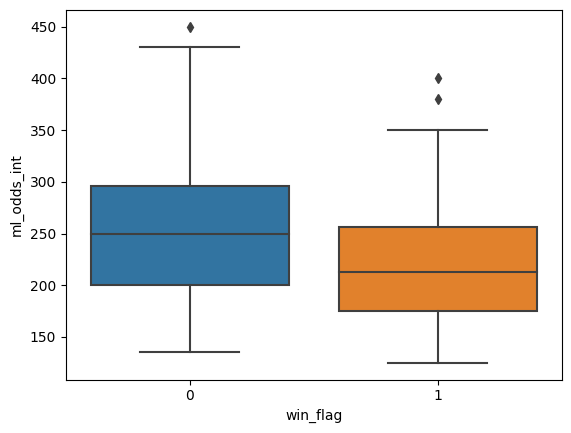

In [230]:
# Distribution of odds of the bets places
bets_placed['ml_odds_int'] = bets_placed['ml_odds'].astype(int)
sns.boxplot(data = bets_placed, x = 'win_flag', y = 'ml_odds_int')

<Axes: xlabel='ml_odds_int', ylabel='Count'>

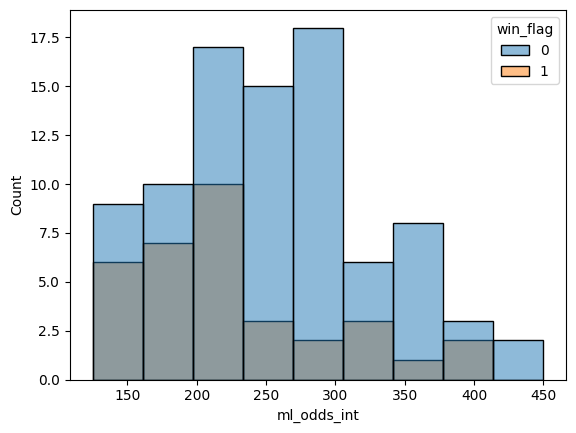

In [231]:
sns.histplot(data = bets_placed, x = 'ml_odds_int', hue = 'win_flag')

<Axes: xlabel='xG', ylabel='Count'>

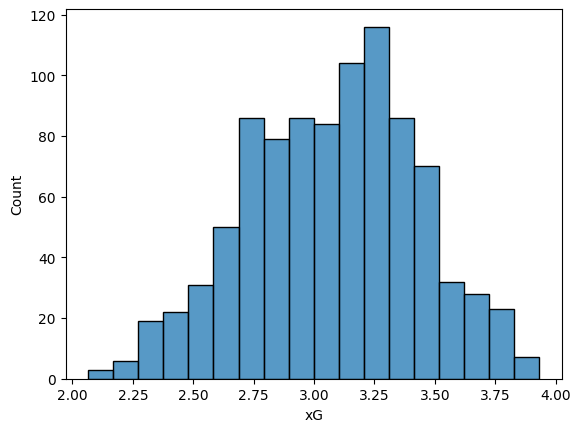

In [232]:
sns.histplot(team_xG, x = 'xG')